# 3. Modelling

## 3.1. Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

base_path = '/content/drive/MyDrive/nlp/amazon'
reviews_train_df = pd.read_csv(base_path + '/data/preproc_pet_supplies_train.csv')
reviews_test_df = pd.read_csv(base_path + '/data/preproc_pet_supplies_test.csv')

In [ ]:
X_train = reviews_train_df['preprocReviewText'].values
y_train = reviews_train_df['sentiment'].values

X_test = reviews_test_df['preprocReviewText'].values
y_test = reviews_test_df['sentiment'].values

## 3.2. Model training

### 3.2.1. XGBoost Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Feature extraction
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
import sklearn.preprocessing as pr

X_train_vec = pr.normalize(X_train_vec, axis=1)
X_test_vec = pr.normalize(X_test_vec, axis=1)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

max_depth = [10, 15, 20]
n_estimators = [100, 200, 500]
#learning_rate = [1e-3, 1e-2, 1e-1]

param_grid_xgb = {"max_depth": max_depth,
                  "n_estimators": n_estimators,
                  #"learning_rate": learning_rate
                  }

grid_xgb = GridSearchCV(XGBClassifier(random_state=0), param_grid=param_grid_xgb, cv=5, verbose=2)
grid_xgb.fit(X_train_vec, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=  17.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=  18.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=  16.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=  18.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=  27.6s
[CV] END .....................max_depth=10, n_estimators=200; total time=  46.7s
[CV] END .....................max_depth=10, n_estimators=200; total time=  32.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=  32.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=  42.5s
[CV] END .....................max_depth=10, n_estimators=200; total time=  40.3s
[CV] END .....................max_depth=10, n_estimators=500; total time= 2.0min
[CV] END .....................max_depth=10, n_est

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [ ]:
# Best parameters
best_params_xgb = grid_xgb.best_params_
best_score_xgb = grid_xgb.best_score_

print(f"Best parameters: {best_params_xgb}")
print(f"Best mean cross-validation score: {best_score_xgb:.4f}")

Best parameters: {'max_depth': 15, 'n_estimators': 200}
Best mean cross-validation score: 0.8462


In [ ]:
# Train the model
xgb_model = XGBClassifier(random_state=0,
                          learning_rate=0.1,
                          max_depth=7,
                          n_estimators=150).fit(X_train_vec, y_train)

print(f"Train accuracy: {xgb_model.score(X_train_vec, y_train):.4f}")
print(f"Test accuracy: {xgb_model.score(X_test_vec, y_test):.4f}")

Train accuracy: 0.8886
Test accuracy: 0.8312


In [ ]:
# Model prediction on testing set
yhat_xgb = xgb_model.predict(X_test_vec)

### 3.2.2. LSTM Network

In [ ]:
reviews = [review for review in reviews_train_df['preprocReviewText']]
vocabulary_size = len(set(' '.join(reviews).split()))

In [ ]:
words = reviews_train_df['preprocReviewText'].map(lambda s: len(s.split()))
max_words = int(words.mean() + words.std())
words.describe()

count    16226.000000
mean        22.874214
std         31.641895
min          1.000000
25%          6.000000
50%         14.000000
75%         28.000000
max       1234.000000
Name: preprocReviewText, dtype: float64

In [ ]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X_train)

# Feature extraction
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_words)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_words)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, LeakyReLU

embedding_size = 300
lstm_model = Sequential()
lstm_model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(8, activation=LeakyReLU(alpha=0.05), kernel_regularizer='l1'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 300)           4723500   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4766397 (18.18 MB)
Trainable params: 47663

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History

# Compile the model
lstm_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=1e-4),
                   metrics=['accuracy'])

# Set history and early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=0,
                              restore_best_weights=True,
                              mode='auto')

# Train the model
lstm_model.fit(X_train_seq,
               y_train,
               batch_size=64,
               epochs=10,
               validation_split=0.15,
               callbacks=[history, earlystopping])

Epoch 1/10
216/216 [==============================] - 6s 15ms/step - loss: 1.1371 - accuracy: 0.5497 - val_loss: 1.1025 - val_accuracy: 0.6668
Epoch 2/10
216/216 [==============================] - 2s 9ms/step - loss: 1.0670 - accuracy: 0.6250 - val_loss: 1.0168 - val_accuracy: 0.7375
Epoch 3/10
216/216 [==============================] - 2s 8ms/step - loss: 0.9551 - accuracy: 0.7176 - val_loss: 0.8639 - val_accuracy: 0.7970
Epoch 4/10
216/216 [==============================] - 2s 9ms/step - loss: 0.8331 - accuracy: 0.7906 - val_loss: 0.7632 - val_accuracy: 0.8242
Epoch 5/10
216/216 [==============================] - 2s 8ms/step - loss: 0.7475 - accuracy: 0.8284 - val_loss: 0.6940 - val_accuracy: 0.8463
Epoch 6/10
216/216 [==============================] - 2s 8ms/step - loss: 0.6851 - accuracy: 0.8485 - val_loss: 0.6507 - val_accuracy: 0.8426
Epoch 7/10
216/216 [==============================] - 2s 10ms/step - loss: 0.6350 - accuracy: 0.8627 - val_loss: 0.6113 - val_accuracy: 0.8480
Epoc

In [ ]:
from matplotlib import pyplot as plt

# Plot training-and-validation loss and accuracy metrics
def history_loss_accuracy(history):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["accuracy"], label="train_acc")
    plt.plot(history.history["val_accuracy"], label="val_acc")
    plt.title("Training vs Validation Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

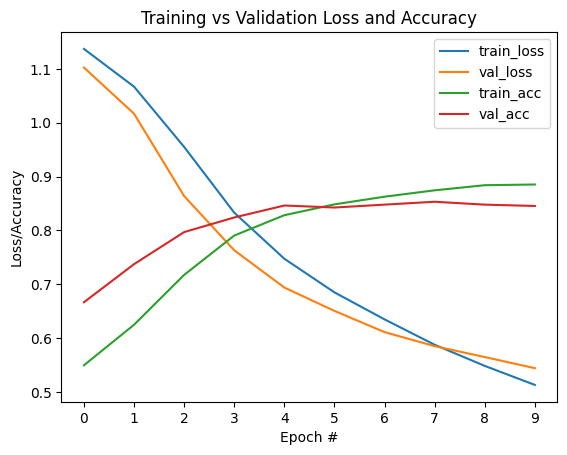

In [ ]:
history_loss_accuracy(history)

In [ ]:
# Test scores
scores = lstm_model.evaluate(X_test_seq, y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

127/127 [==============================] - 0s 3ms/step - loss: 0.5464 - accuracy: 0.8563
Test Loss: 0.5464
Test Accuracy: 0.8563


In [ ]:
# Model prediction on testing set
yhat_lstm = lstm_model.predict(X_test_seq)

127/127 [==============================] - 2s 8ms/step


### 3.2.3. GPT-2

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2Tokenizer
import tensorflow as tf

# Model tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_ = lambda review: tokenizer(review,
                                      max_length=max_words,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')

X_train_input = [tokenizer_(review)['input_ids'] for review in X_train]
X_train_input = tf.squeeze(tf.convert_to_tensor(X_train_input), axis=1)
X_train_mask = [tokenizer_(review)['attention_mask'] for review in X_train]
X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask), axis=1)

X_test_input = [tokenizer_(review)['input_ids'] for review in X_test]
X_test_input = tf.squeeze(tf.convert_to_tensor(X_test_input), axis=1)
X_test_mask = [tokenizer_(review)['attention_mask'] for review in X_test]
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask), axis=1)

y_train_input = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_input = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [ ]:
from transformers import TFGPT2Model

# Load GPT2 pre-trained model
base_model = TFGPT2Model.from_pretrained('gpt2')
base_model.training = True

# Resize model embedding to match new tokenizer
base_model.resize_token_embeddings(len(tokenizer))
base_model.config.pad_token_id = base_model.config.eos_token_id

# Freeze model layers
for layer in base_model.layers:
    layer.trainable = False

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
base_model.summary()

Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  124439808 
 er)                                                             
                                                                 
Total params: 124439808 (474.70 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 124439808 (474.70 MB)
_________________________________________________________________


In [ ]:
from keras.layers import Input

# Transfer Learning
input = Input(shape=(None,), dtype='int32')
mask = Input(shape=(None,), dtype='int32')
x = base_model(input, attention_mask=mask)
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

gpt2_model = tf.keras.Model([input, mask], output)
gpt2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 tfgpt2_model (TFGPT2Model)  TFBaseModelOutputWithPastA   1244398   ['input_1[0][0]',             
                             ndCrossAttentions(last_hid   08         'input_2[0][0]']             
                             den_state=(None, None, 768                                           
                             ),                                                               

In [ ]:
# Compile the model
gpt2_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=1e-4),
                   metrics=['accuracy'])

# Set history and early-stopping callbacks
history = History()
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=0,
                              restore_best_weights=True,
                              mode='auto')

# Train the model on new data
gpt2_model.fit([X_train_input, X_train_mask],
               y_train_input,
               batch_size=64,
               epochs=25,
               validation_split=0.15,
               callbacks=[history, earlystopping])

Epoch 1/25
216/216 [==============================] - 81s 297ms/step - loss: 0.8147 - accuracy: 0.5570 - val_loss: 0.6345 - val_accuracy: 0.6569
Epoch 2/25
216/216 [==============================] - 63s 294ms/step - loss: 0.6259 - accuracy: 0.6592 - val_loss: 0.5850 - val_accuracy: 0.7112
Epoch 3/25
216/216 [==============================] - 63s 294ms/step - loss: 0.5850 - accuracy: 0.7045 - val_loss: 0.5569 - val_accuracy: 0.7182
Epoch 4/25
216/216 [==============================] - 64s 295ms/step - loss: 0.5532 - accuracy: 0.7362 - val_loss: 0.5337 - val_accuracy: 0.7465
Epoch 5/25
216/216 [==============================] - 65s 300ms/step - loss: 0.5345 - accuracy: 0.7438 - val_loss: 0.5177 - val_accuracy: 0.7543
Epoch 6/25
216/216 [==============================] - 65s 300ms/step - loss: 0.5218 - accuracy: 0.7522 - val_loss: 0.5046 - val_accuracy: 0.7638
Epoch 7/25
216/216 [==============================] - 63s 294ms/step - loss: 0.5086 - accuracy: 0.7590 - val_loss: 0.5013 - val_ac

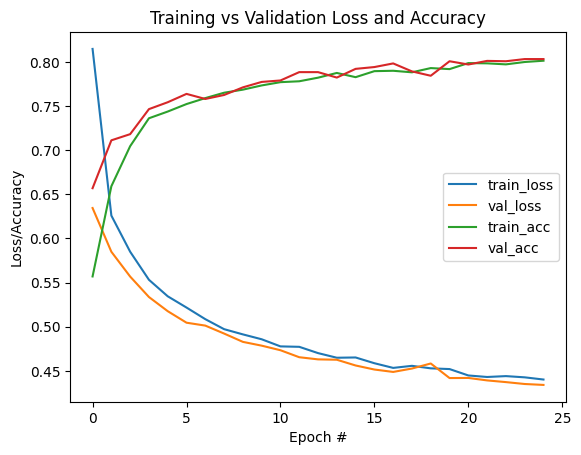

In [ ]:
history_loss_accuracy(history)

In [ ]:
# Test scores
scores = gpt2_model.evaluate([X_test_input, X_test_mask], y_test)
print(f"Test Loss: {scores[0]:.4f}")
print(f"Test Accuracy: {scores[1]:.4f}")

127/127 [==============================] - 19s 122ms/step - loss: 0.4371 - accuracy: 0.7991
Test Loss: 0.4371
Test Accuracy: 0.7991


In [ ]:
# Model prediction on testing set
yhat_gpt2 = gpt2_model.predict([X_test_input, X_test_mask])

127/127 [==============================] - 18s 123ms/step


## 3.3. Save models and predictions

In [ ]:
!mkdir '{base_path}/models' '{base_path}/predictions'

In [ ]:
import pickle

pickle.dump(xgb_model, open(base_path + '/models/xgb_model.pkl', 'wb'))
keras.models.save_model(lstm_model, base_path + '/models/lstm_model.keras')
keras.models.save_model(gpt2_model, base_path + '/models/gpt2_model.keras', save_format='tf')

In [ ]:
testpredictions_df = pd.DataFrame({'sentiment': y_test,
                                   'xgb_pred': yhat_xgb,
                                   'lstm_pred': yhat_lstm.reshape(-1),
                                   'gpt2_pred': yhat_gpt2.reshape(-1)})
testpredictions_df.to_csv(base_path + '/predictions/test_predictions.csv', index=False)

## 3.4. Comments

Se han utilizado tres modelos con los que entrenar los datos preprocesados:
- **XGBoost**: Con la profundidad de los árboles y el número de estimadores óptimos el modelo daba problemas de sobreajuste, por lo que se han ajustado los hiperparámetros tratando de reducir este problema, obteniendo un *accuracy* en el cojunto de test del $83.12\%$.

- **Red LSTM**: Dadas las características del problema de clasificación, se ha optado por utilizar este tipo de red neuronal recurrente buscando que el modelo sea capaz de recoger la información relevante de cada review, para prevenir el overfitting se ha utilizado la regularización L1 junto con capas de dropout. Respecto al *accuracy*, ha sido del $85.63\%$ en el cojunto de test, el mejor de los tres modelos.

- **GPT-2**: Partiendo del modelo preentrenado GPT-2 como base, se ha utilizado la técnica de transfer learing tomando la salida transformada del modelo GPT-2 como entrada de otro modelo de clasificación formado por dos capas fully-connected. No presenta síntomas de overfitting con un *accuracy* en el cojunto de test del $79.91\%$.
